In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
config = {}

config['path_to_data'] = data_path+"ids/data/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

## experiment 1
config['date1'] = "2024-01-29"
config['date2'] = "2024-02-05"

## experiment 2
config['date1'] = "2024-02-15"
config['date2'] = "2024-02-23"

## experiment 3
config['date1'] = "2024-03-09"
config['date2'] = "2024-04-09"

## experiment 4
config['date1'] = "2024-03-09"
config['date2'] = "2024-04-28"


In [5]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [6]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [7]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [8]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'])

2024-03-09
2024-03-10
2024-03-11
2024-03-12
2024-03-13
error for 20240313.pkl
2024-03-14
error for 20240314.pkl
2024-03-15
2024-03-16
2024-03-17
2024-03-18
2024-03-19
2024-03-20
error for 20240320.pkl
2024-03-21
2024-03-22
2024-03-23
2024-03-24
2024-03-25
2024-03-26
2024-03-27
2024-03-28
2024-03-29
2024-03-30
2024-03-31
2024-04-01
2024-04-02
2024-04-03
2024-04-04
2024-04-05
2024-04-06
2024-04-07
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-13
2024-04-14
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19
2024-04-20
2024-04-21
2024-04-22
2024-04-23
2024-04-24
2024-04-25
2024-04-26
2024-04-27
2024-04-28


### Remove MLTI times

In [9]:

# local time to utc (! correct only in winter)
df['time_utc'] = [UTCDateTime(tl)-3600 for tl in df.time]


# pixel to length
conversion_factor = 1.67e-3 # mm / pixel

keys_to_convert = ["y_idx", "x_idx", "y", "x"]

for k in keys_to_convert:
    df[k] *= conversion_factor

# turn times with MLTI to NaN
df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)


In [10]:
df

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,...,y_var,amp_var,y_sig_var,x_sig_var,theta_var,offset_var,time_sec,time_utc,y_idx_nan,x_idx_nan
0,2024-03-09T00:16:04.000000Z,3.448152,1.623167,3.44688,1.62324,118.640974,512.482534,488.616501,0.442582,9.262870,...,0.004833,0.000277,0.006100,0.006563,0.000004,0.000021,0.0,2024-03-08T23:16:04.000000Z,1.62324,3.44688
1,2024-03-09T00:18:04.000000Z,3.448166,1.623070,3.44688,1.62324,118.576590,512.446876,488.572016,0.442970,9.261224,...,0.004832,0.000277,0.006098,0.006561,0.000004,0.000021,120.0,2024-03-08T23:18:04.000000Z,1.62324,3.44688
2,2024-03-09T00:32:04.000000Z,3.448276,1.623338,3.44688,1.62324,118.430879,512.472021,488.643493,0.443508,9.262004,...,0.004837,0.000276,0.006104,0.006567,0.000004,0.000021,960.0,2024-03-08T23:32:04.000000Z,1.62324,3.44688
3,2024-03-09T00:45:05.000000Z,3.448335,1.623647,3.44688,1.62324,118.532076,512.453585,488.643372,0.443924,9.255072,...,0.004839,0.000277,0.006106,0.006569,0.000004,0.000021,1741.0,2024-03-08T23:45:05.000000Z,1.62324,3.44688
4,2024-03-09T00:51:04.000000Z,3.448354,1.623493,3.44688,1.62324,118.460598,512.491885,488.660101,0.443797,9.259604,...,0.004840,0.000277,0.006107,0.006571,0.000004,0.000021,2100.0,2024-03-08T23:51:04.000000Z,1.62324,3.44688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,2024-04-28T22:17:05.000000Z,3.651679,1.658471,3.65062,1.65831,123.857327,516.286461,488.762571,0.473005,10.726966,...,0.005378,0.000335,0.006746,0.007404,0.000004,0.000026,4399261.0,2024-04-28T21:17:05.000000Z,1.65831,3.65062
6666,2024-04-28T22:58:04.000000Z,3.651545,1.658024,3.65062,1.65664,123.396727,516.277891,488.770618,0.474344,10.727196,...,0.005377,0.000332,0.006743,0.007401,0.000004,0.000026,4401720.0,2024-04-28T21:58:04.000000Z,1.65664,3.65062
6667,2024-04-28T23:14:04.000000Z,3.651577,1.657845,3.65062,1.65664,123.340598,516.297814,488.772991,0.474428,10.725474,...,0.005376,0.000332,0.006742,0.007400,0.000004,0.000026,4402680.0,2024-04-28T22:14:04.000000Z,1.65664,3.65062
6668,2024-04-28T23:38:05.000000Z,3.651535,1.657759,3.65062,1.65664,123.302898,516.266447,488.704794,0.472777,10.725790,...,0.005374,0.000332,0.006740,0.007398,0.000004,0.000026,4404121.0,2024-04-28T22:38:05.000000Z,1.65664,3.65062


### Plotting

In [11]:
from functions.reduce import __reduce

In [12]:
df['x_um_rel'] = __reduce(df.x, 10) * 1e3
df['y_um_rel'] = __reduce(df.y, 10) * 1e3

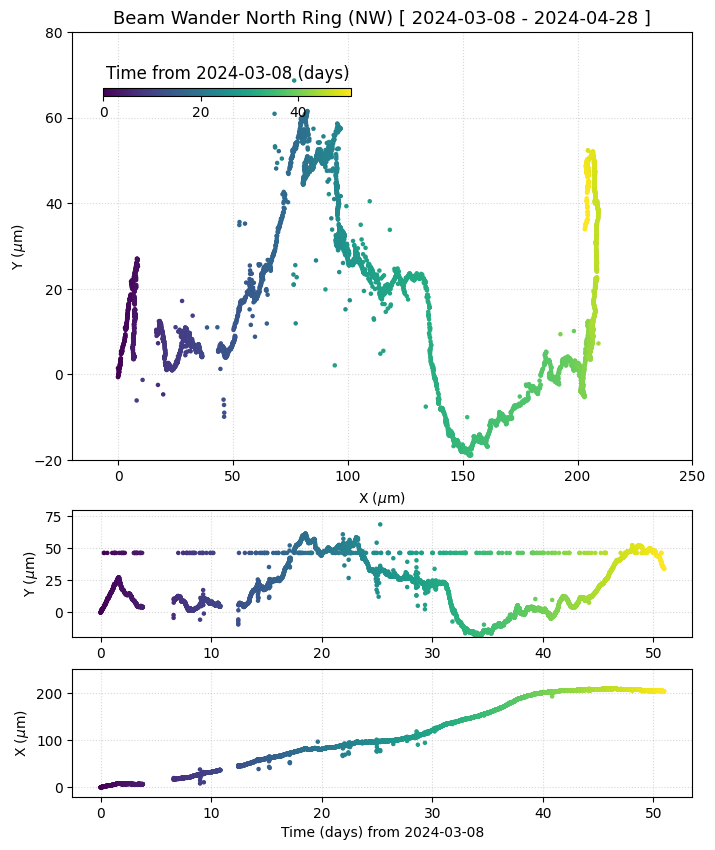

In [35]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    # ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # cb = ax1.scatter(df0.x, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    # ax2.scatter(df0.time_sec*time_scaling, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # ax3.scatter(df0.time_sec*time_scaling, df0.x, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y ($\mu$m)")
    ax1.set_xlabel("X ($\mu$m)")

    ax2.set_ylabel("Y ($\mu$m)")
    # ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("X ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    # x1, x2 = 3.44, 3.52
    # y1, y2 = 1.62, 1.66
    x1, x2 = -20, 250
    y1, y2 = -20, 80
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.05, 0.85, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)


    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BeamWander_RU_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')


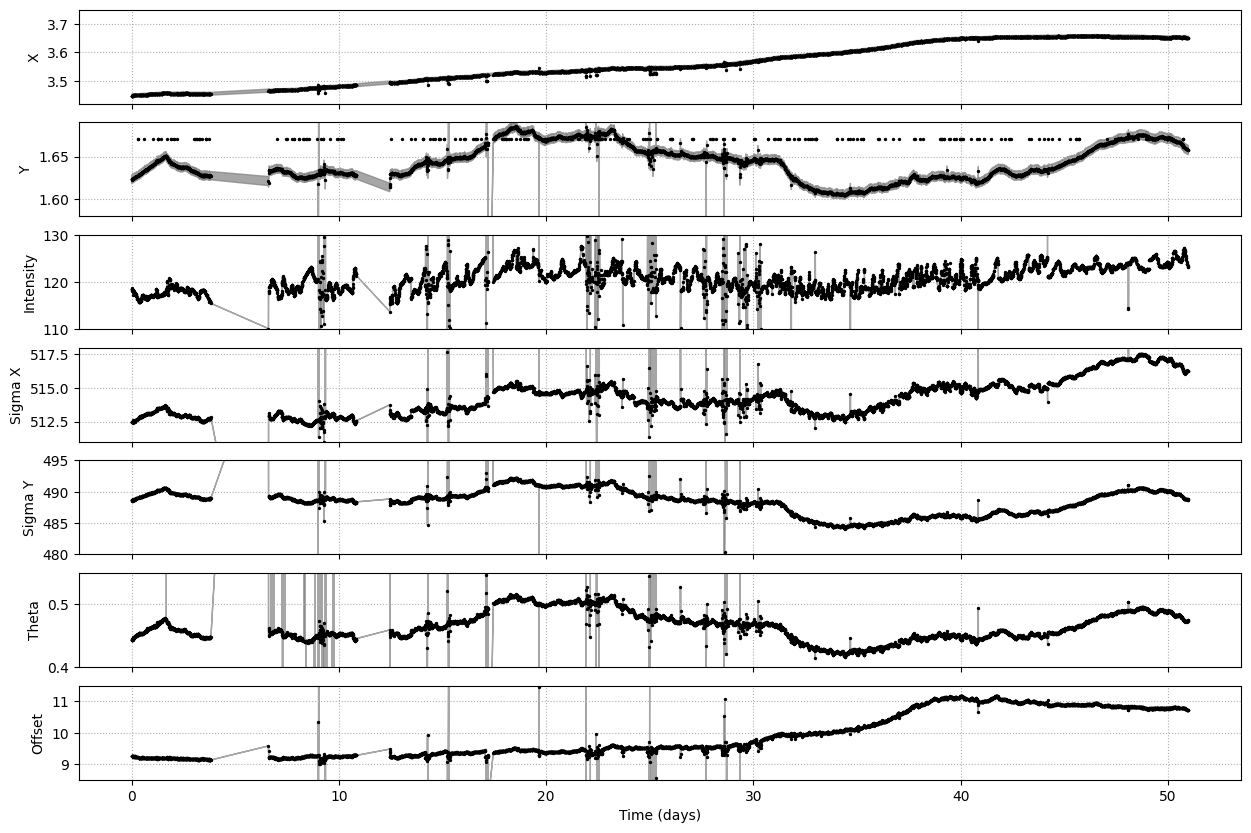

In [51]:
def __makeplot():

    Nrow, Ncol = 7, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    ax[0].fill_between(df.time_sec*tscale, df.x-df.x_var, df.x+df.x_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[0].scatter(df.time_sec*tscale, df.x, s=size, zorder=2, color="k")
    ax[0].set_ylim(3.42, 3.75)
    ax[0].set_ylabel("X")

    ax[1].fill_between(df.time_sec*tscale, df.y-df.y_var, df.y+df.y_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[1].scatter(df.time_sec*tscale, df.y, s=size, zorder=2, color="k")
    ax[1].set_ylim(1.58, 1.69)
    ax[1].set_ylabel("Y")

    ax[2].fill_between(df.time_sec*tscale, df.amp-df.amp_var, df.amp+df.amp_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[2].scatter(df.time_sec*tscale, df.amp, s=size, zorder=2, color="k")
    ax[2].set_ylim(110, 130)
    ax[2].set_ylabel("Intensity")

    ax[3].fill_between(df.time_sec*tscale, df.x_sig-df.x_sig_var, df.x_sig+df.x_sig_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[3].scatter(df.time_sec*tscale, df.x_sig, s=size, zorder=2, color="k")
    ax[3].set_ylim(511, 518)
    ax[3].set_ylabel("Sigma X")

    ax[4].fill_between(df.time_sec*tscale, df.y_sig-df.y_sig_var, df.y_sig+df.y_sig_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[4].scatter(df.time_sec*tscale, df.y_sig, s=size, zorder=2, color="k")
    ax[4].set_ylim(480, 495)
    ax[4].set_ylabel("Sigma Y")

    ax[5].fill_between(df.time_sec*tscale, df.theta-df.theta_var, df.theta+df.theta_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[5].scatter(df.time_sec*tscale, df.theta, s=size, zorder=2, color="k")
    ax[5].set_ylim(0.4, 0.55)
    ax[5].set_ylabel("Theta")

    ax[6].fill_between(df.time_sec*tscale, df.offset-df.offset_var, df.offset+df.offset_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[6].scatter(df.time_sec*tscale, df.offset, s=size, zorder=2, color="k")
    ax[6].set_ylim(8.5, 11.5)
    ax[6].set_ylabel("Offset")

    ax[6].set_xlabel("Time (days)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figures']+f"BeamWander_RU_parameters_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')
